### 🖋 **Notebook Contents**

0. Initial Setup
1. Business Problem Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Conclusion
6. Recommendation

****

## `Initial Setup`

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import lines, patches
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
import category_encoders as ce # BinaryEncoder
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# my own function
import function as fnk

import warnings
warnings.filterwarnings("ignore")

## `Business Problem`

<h1><center> <span style="color:#0ad0f7">Hotel Booking Demand</span></center></h1>

**Context**:
<br>
Terdapat sebuah perusahaan yang bergerak dibidang hospitality industry-khususnya perhotelan-dan berlokasi di Portugal, memiliki dataset yang telah diekstrak dari database hotel (Property Management System (PMS)). Hospitality industry lebih fokus dengan kepuasan pelanggan. Berdasarkan [The Big Four](https://www.hospitalitynet.org/opinion/4082318.html), ada bermacam-macam hospitality industry, seperti Food and Beverages, Travel and Tourism, Lodging, dan Recreation. Industri hotel termasuk ke dalam lodging, salah satu permasalahan yang sering terjadi pada industri hotel adalah pembatalan pesanan oleh pelanggan. Salah satu cara pemesanan kamar pada perusahaan hotel ini adalah dengan melakukan pemesanan terlebih dahulu sebelum tanggal menginap (booking system).

Target (is_canceled):

1 : pesanan yang dibatalkan (positif)

0 : pesanan yang **tidak** dibatalkan (negatif)

**Project Stakeholders**:
<br>
Stakeholders yang akan menggunakan model ini adalah:
1. Marketing & Sales Departement : Departement ini bertanggungjawab untuk memaksimalkan revenue dengan cara melakukan beberapa strategi marketing (ex: promosi/diskon) kepada pelanggan, sehingga dengan model ini Marketing dan Sales Departement bisa mengetahui pelanggan yang **tepat** untuk diberi promosi/diskon.
2. Finance Departement : Salah satu tugas Finance Departement adalah mengatur pemasukan dan pengeluaran keuangan perusahaan yang salah satunya diakibatkan dari promosi/campaign yang diadakan Marketing dan Sales Departement. 

Pada dasarnya, kedua departement ini saling berkesinambungan dan memiliki pertanyaan/tujuan yang sama, yaitu **bagaimana caranya memaksimalkan revenue perusahaan.**

**Prolem Statement**:
<br>
Ada beberapa problem yang sering terjadi di hotel industry, salah satunya adalah pembatalan pesanan yang telah dilakukan. Berdasarkan referensi dibawah, cancellation rate secara global berada pada angka **33%** pada tahun 2014 dan **40%** pada tahun 2018, sedangkan pada dataset ini cancellation rate-nya sebesar **37%**. Hal ini menunjukkan adanya peningkatan cancellation rate pada tahun-tahun tersebut dan tentu saja memberikan dampak **negatif** bagi revenue perusahaan. Revenue loss akibat dari pesanan yang dibatalkan dapat mencapai **15%**.

Sampai saat ini pihak hotel masih melakukan prediksi pembatalan pesanan dengan cara manual, sehingga penawaran/marketing yang dilakukan kurang tepat sasaran. Hal ini tentu berdampak bagi pihak hotel pada tidak maksimalnya revenue yang didapatkan. 

Reference:
1. [Global Cancellation Rate Hotel Reservations Reacehs 40 average](https://hospitalitytech.com/global-cancellation-rate-hotel-reservations-reaches-40-average)
2. [How Hotels Can Combat Rising Cancellation Rates](https://resources.emerchantpay.com/how-hotels-can-combat-rising-cancellation-rates)
3. [Revenue Loss Due to Cancellations](https://revenue-hub.com/three-most-common-trends-impacting-cancellation-rates/)

**Goals**:
<br>
Perusahaan ingin mengetahui atau **memprediksi apakah suatu pelanggan akan membatalkan pesanan atau tidak**. Dengan mengidentifikasi **pesanan mana yang kemungkinan dibatalkan**, pihak hotel dapat **menawarkan layanan lainnya** seperti, diskon, tiket masuk ke pertunjukkan/taman hiburan, ataupun hal lainnya. Akan tetapi, penawaran-penawaran ini mungkin tidak dapat selalu diterapkan, mengingat tingkat keekonomian/kesensitifan pelanggan berbeda-beda, contoh tamu perusahaan (coorporate guest). Penawaran ini dilakukan dengan tujuan pihak hotel sebisa mungkin perusahaan tidak kehilangan potential customer/pelanggan, sehingga dapat meningkatkan revenue perusahaan.

**Analytic Approach**:
<br>
Jadi yang akan kita lakukan adalah menganalisis data untuk menemukan pola yang membedakan pelanggan yang akan membatalkan pesanan atau tidak.

Kemudian kita akan membangun model `klasifikasi` yang akan membantu perusahaan untuk dapat memprediksi pelanggan yang akan membatalkan pesanan atau tidak.

**Metric Evaluation**:
<br>
Type I Error: False Positive
<br>
Kondisi di mana pelanggan terprediksi **membatalkan** pesanan padahal kenyataannya tidak membatalkan pesanan
<br>
`Konsekuensinya:` promosi tidak tepat sasaran, sehingga revenue tidak maksimal. Tanpa mengadakan marketing, pihak hotel bisa mendapatkan **101 USD**.

Type II Error: False Negative
<br>
Kondisi di mana pelanggan terprediksi tidak membatalkan pesanan padahal kenyataannya membatalkan pesanan
<br>
`Konsekuensinya:` pihak hotel kehilangan potential pelanggan dan tentu saja berdampak pada kehilangan revenue. Berdasarkan referensi di bawah, rata-rata biaya marketing adalah **7%-11%**. Sehingga, untuk worst case-nya pihak hotel mendapatkan revenue **90 USD** setelah dikurangi dengan **11% biaya marketing**.

Oleh karena itu, berdasarkan hal-hal diatas, maka sebisa mungkin yang akan kita lakukan adalah membuat model yang dapat memprediksi **sebanyak mungkin kelas positif dan kelas negatif yang benar dan meminimalkan type I error dan type II error**. Jadi, nanti metric utama yang digunakan adalah `MCC (Matthew Correlation Coefficient) and Balanced Accucary`.

Referensi:
1. [Hotel Marketing Budgets: How Much Is Actually Enough?](https://www.hospitalitynet.org/opinion/4090018.html)
2. [The Digital Marketing Experts for Independent Hotels & Management Companies](https://www.orourkehospitality.com/resources/topic/hospitality-digital-marketing/4-tips-for-planning-your-2022-hospitality-marketing-budget/)
3. [Hotel Booking Demand Datasets](https://drive.google.com/file/d/1qJd9Ym_XD8NjFu2DncnhTvbinOeZ_lbU/view?usp=sharing)
4. [The advantages of the Matthews correlation coefficient (MCC) over F1 score and accuracy in binary classification evaluation](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7)

---
---

## `Data Understanding`

Dataset dapat di akses pada link berikut: [dataset!](https://drive.google.com/drive/folders/17KIeOXK7eYGuzgpn_IljlUFcE4v96lSL)

| Columns                                            | Definition                                                   | 
| ------------------------------------------------- | ------------------------------------------------------------ |
| `country` | country of origin |
| `market_segment` | Market segment designation |
| `previous_cancellations` | Number of previous bookings that were cancelled by the customer prior to the current booking |
| `booking_changes` | Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation |
| `deposit_type` | Indication on if the customer made a deposit to guarantee the booking |
| `days_in_waiting_list` |  Number of days the booking was in the waiting list before it was confirmed to the customer |
| `customer_type` | Type of booking |
| `reserved_room_type` | Code of room type reserved. Code is presented instead of designation for anonymity reasons |
| `required_car_parking_space` | Number of car parking spaces required by the customer |
| `total_of_special_request` | Number of special requests made by the customer (e.g. twin bed or high floor) |
| `is_canceled` | Value indicating if the booking was canceled (1) or not (0) |

In [53]:
data = pd.read_csv(r"C:\Users\faisa\Desktop\DataSciencePurwadhika\Modul3ML\HotelBookingDemand\data\raw\data_hotel_booking_demand.csv")
data.sample(10)

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
54031,FRA,Groups,0,0,No Deposit,0,Transient-Party,A,0,0,0
18377,PRT,Online TA,0,0,No Deposit,0,Transient,A,0,1,0
61341,PRT,Corporate,0,0,No Deposit,0,Transient-Party,A,0,0,0
15931,PRT,Groups,0,0,No Deposit,0,Transient-Party,A,0,0,0
45991,PRT,Offline TA/TO,0,0,Non Refund,0,Transient-Party,A,0,0,1
63895,ESP,Direct,0,0,No Deposit,0,Transient,A,0,1,0
54346,ESP,Online TA,0,0,No Deposit,0,Transient,D,1,3,0
3131,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,1,0
80355,PRT,Offline TA/TO,0,0,No Deposit,0,Transient,D,0,0,1
79017,ITA,Online TA,0,1,No Deposit,0,Transient-Party,A,0,2,0


In [9]:
display(
    # numerical variable
    data.describe(),
    # categorical variable
    data.describe(include='object')
)

,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,is_canceled
count,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000
mean,0.086798,0.220897,2.330561,0.062999,0.573211,0.368277
std,0.841011,0.648635,17.673051,0.246919,0.795163,0.482340
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,26.000000,21.000000,391.000000,8.000000,5.000000,1.000000


,country,market_segment,deposit_type,customer_type,reserved_room_type
count,83222,83573,83573,83573,83573
unique,162,8,3,4,10
top,PRT,Online TA,No Deposit,Transient,A
freq,34097,39460,73352,62732,60041


**_Insight_:**
- nilai mininum dan maksimum pada semua kolom bervariasi
- perlu melakukan **re-scalling** jika menggunakan model yang berbasis **jarak (distance)**
- persebaran value pada kolom day_in_waiting_list besar, hal ini ditunjukkan dengan nilai standar deviasinya sebesar 17.67

In [10]:
# jumlah baris dan kolom
print(f'Jumlah baris dan kolom: {data.shape[0]} baris dan {data.shape[1]} kolom')

# cek duplikat
print(f"Jumlah data duplikat : \x1b[31m{data[data.duplicated()].shape[0]} baris\x1b[0m")

# cek kualitas DataFrame
fnk.qualitydf(data)

Jumlah baris dan kolom: 83573 baris dan 11 kolom
Jumlah data duplikat : 73371 baris


,columns,data_type,null_value(%),n_unique,zero_value,neg_value,sample_unique
0,country,object,0.419992,162,False,False,"[IRL, FRA, PRT, NLD, ESP, UMI, CN, LUX, BRA, BEL, JPN, DEU, ITA, CHE, GBR, AGO, SRB, COL, CHN, SWE, AUT, CIV, CZE, POL, USA, SGP, RUS, ROU, DNK, IND, MAR, PHL, ARG, ISL, ZAF, LBN, MOZ, TUR, BGD, MEX, CAF, NOR, FIN, UKR, EGY, ISR, nan, KOR, AZE, HUN, AUS, EST, CHL, SVN, PRY, ABW, ALB, LTU, ARE, HRV, SAU, NZL, LVA, ATA, KAZ, DZA, TWN, CRI, BIH, BGR, IRQ, OMN, VEN, IDN, GEO, MLT, IRN, BLR, URY, LBY, TUN, BEN, MYS, MWI, GRC, CYP, CPV, HKG, PRI, MKD, MUS, IMN, PAN, NGA, GLP, KHM, PER, QAT, SEN, MAC, ...]"
1,market_segment,object,0.000000,8,False,False,"[Offline TA/TO, Online TA, Direct, Groups, Corporate, Complementary, Aviation, Undefined]"
2,previous_cancellations,int64,0.000000,15,True,False,"[0, 1, 25, 2, 3, 11, 24, 13, 6, 26, 14, 4, 19, 5, 21]"
3,booking_changes,int64,0.000000,19,True,False,"[0, 1, 2, 5, 3, 4, 6, 7, 9, 8, 17, 10, 13, 12, 14, 21, 16, 20, 15]"
4,deposit_type,object,0.000000,3,False,False,"[No Deposit, Non Refund, Refundable]"
5,days_in_waiting_list,int64,0.000000,115,True,False,"[0, 3, 39, 87, 77, 215, 97, 162, 46, 79, 4, 31, 122, 34, 57, 259, 50, 17, 32, 43, 75, 69, 44, 22, 113, 58, 38, 65, 48, 236, 176, 25, 108, 91, 19, 160, 68, 28, 63, 35, 42, 59, 24, 8, 183, 187, 21, 111, 56, 98, 101, 15, 16, 47, 93, 45, 14, 70, 10, 49, 178, 99, 60, 40, 85, 223, 6, 33, 391, 20, 1, 41, 147, 55, 80, 379, 150, 61, 330, 174, 107, 96, 18, 62, 13, 30, 120, 27, 207, 71, 2, 76, 125, 5, 9, 224, 53, 83, 84, 12, ...]"
6,customer_type,object,0.000000,4,False,False,"[Transient-Party, Transient, Contract, Group]"
7,reserved_room_type,object,0.000000,10,False,False,"[A, E, D, F, B, G, C, H, L, P]"
8,required_car_parking_spaces,int64,0.000000,5,True,False,"[0, 1, 2, 8, 3]"
9,total_of_special_requests,int64,0.000000,6,True,False,"[0, 2, 1, 3, 4, 5]"


**_Insight_:**
1. Dataset terdiri dari **83573 baris dan 11 kolom**. Setiap baris data menunjukkan data-data pelanggan/customer yang telah melakukan booking pada hotel. Beberapa data-data pelanggan yang disediakan, seperti negara asal customer, cara customer melakukan pesanan (online, offline, direct, dll), apakah customer pernah melakukan pembatalan pesanan sebelumnya, waktu tunggu konfirmasi dari pihak hotel, dan lain sebagainya. Kemudian, terdapat informasi apakah customer melakukan pembatalan pesanan atau tidak. Berdasarkan informasi-informasi di atas, akan dilakukan pengecekan lebih lanjut faktor-faktor apa saja yang mempengaruhi pembatalan pesanan dan apakah faktor-faktor tersebut tersedia di dalam dataset ini.

2. Jenis variabel data:
<br>
    a. Numerikal
    <br>
        - Discrete : previous_cancellations, booking_changes, days_in_waiting_list, required_car_parking_spaces, total_of_special_request
        <br>
        - Continue : -

    b. Kategorikal
    <br>
        - Nominal : country, market_segment, deposit_type, customer_type, reserved_room_type, is_canceled
        <br>
        - Ordinal : -
3. Tipe data dari setiap variabel sudah sesuai
4. Terdapat missing value pada kolom country sebesar 0.42%
5. Terdapat **73371** baris duplikat

Berdasarkan referensi di bawah, ada beberapa faktor yang dapat mempengaruhi customer melakukan pembatalan pesanan, diantaranya:

    - Jenis ruang yang dipesan oleh customer
    - Platform yang digunakan untuk melakukan pesanan atau melalui siapa customer melakukan pesanan
    - Jenis customer (group or perorangan)
    - Pesanan yang pernah dibatalkan
Data-data diatas sudah terdapat didalam dataset, seperti customer_type, reserved_room_type, previous_cancellations, dan market_segment. Oleh karena itu, dapat dikatakan bahwa dataset ini **bisa menjawab business problem** yang sudah ditentukan diawal. Langkah selanjutnya adalah melakukan Data Preparation, kemudian melakukan pembuatan model machine learning untuk mencari pattern atau pola dari customer yang membatalkan pesanan dan customer yang tidak membatalkan pesanan.

Referensi:
1. [Modelling The Cancellation Behaviour of Hotel Guests](https://core.ac.uk/download/pdf/302225593.pdf)
2. [Predicting Hotel Booking Cancellation to Decrease Uncertainty and Increase Revenue](https://www.researchgate.net/publication/310504011_Predicting_Hotel_Booking_Cancellation_to_Decrease_Uncertainty_and_Increase_Revenue)

### 1️⃣ Numerical Variable

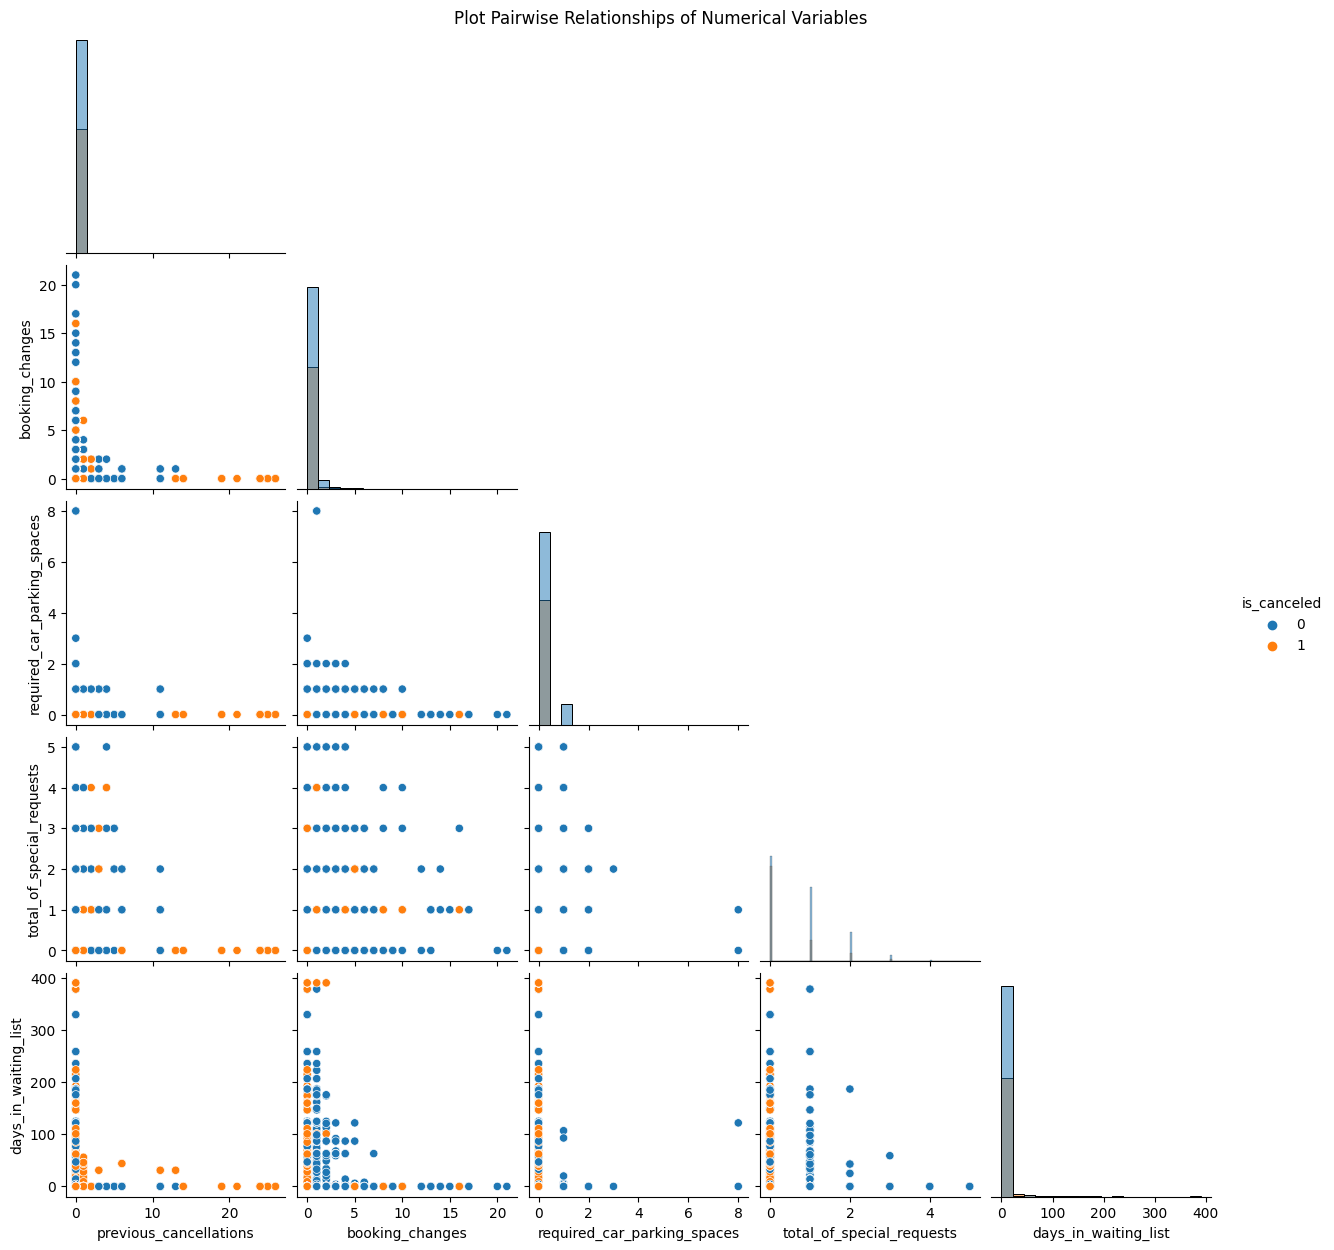

In [7]:
num_cols1 = ['previous_cancellations', 'booking_changes', 'required_car_parking_spaces', 'total_of_special_requests', 'days_in_waiting_list', 'is_canceled']

grph = sns.pairplot(data[num_cols1], corner=True, hue='is_canceled', diag_kind='hist')
grph.fig.suptitle("Plot Pairwise Relationships of Numerical Variables", y=1)
plt.show()

**_Insight_:**
- Pada semua kolom discrete variable, nilai 0 mendominasi daripada nilai lainnya. Untuk penanganan selanjutnya akan dilakukan **diskritisasi**.
- Terdapat bivaraite outlier pada kolom required_car_parking_spaces, ada customer yang meminta 8 parking spaces pada 0 hari waiting list dan 100 hari lebih waiting list (belum dikonfirmasi oleh pihak hotel)

### 2️⃣ Categorical Variable

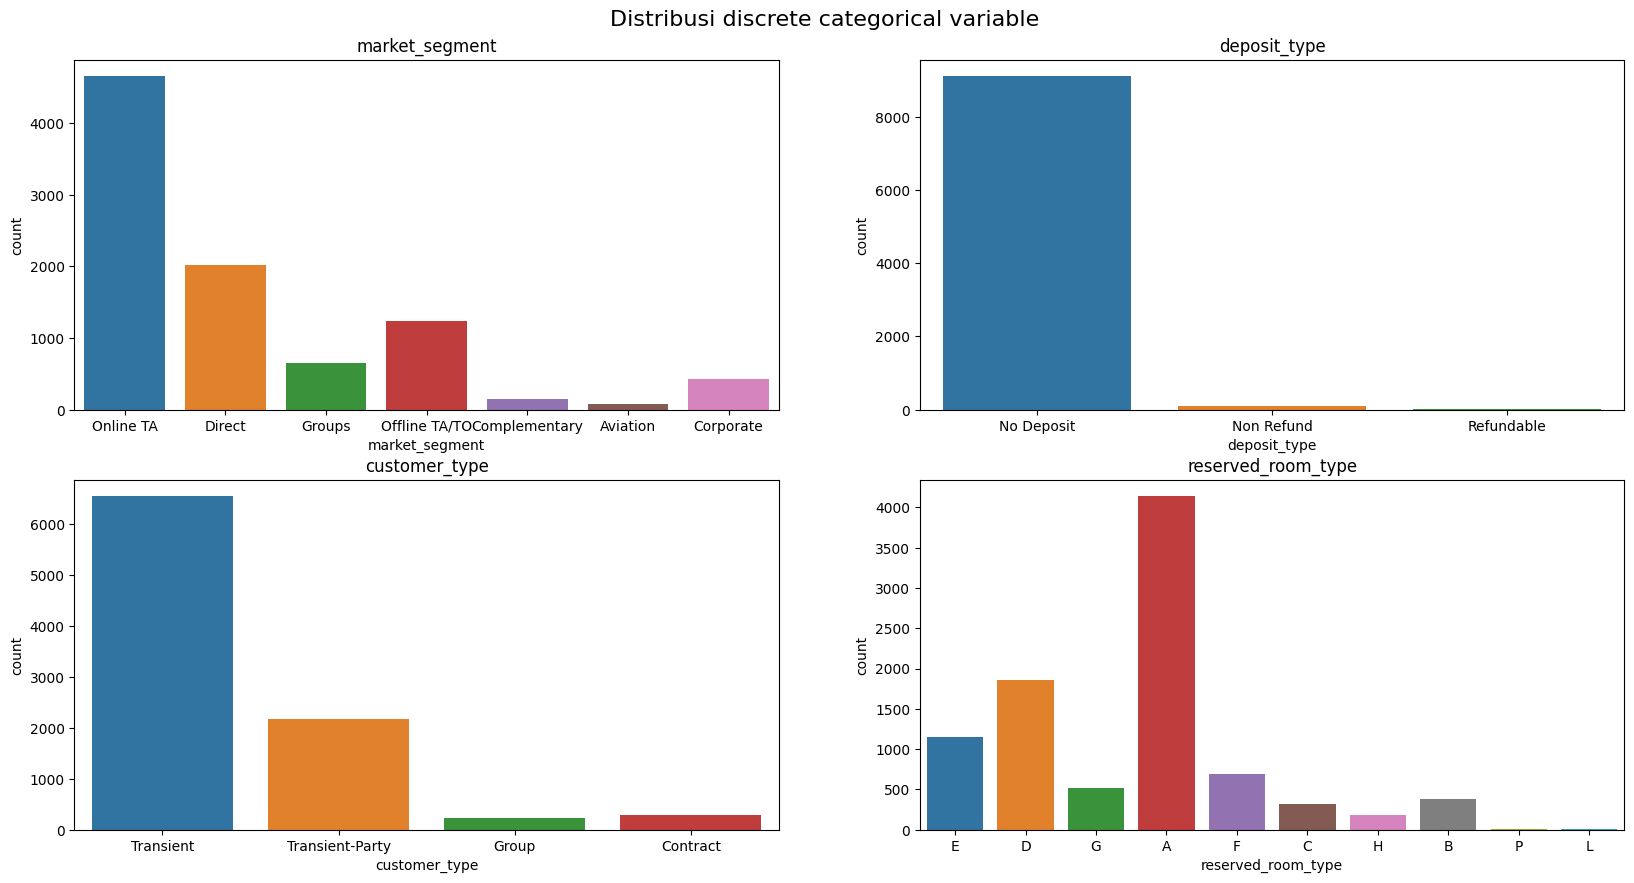

In [81]:
categ_kolom = ['market_segment', 'deposit_type', 'customer_type', 'reserved_room_type']

fnk.countplots_custom(data, categ_kolom, rows=2, cols=2, suptitle="Distribusi discrete categorical variable", size=(20,10))

**_Insight_:**
- Ada beberapa kategori di setiap kolomnya yang mendominasi dan ada beberapa kategori yang bersifat minoritas atau proporsinya data sedikit.
- Pada kolom market_segment, kategori yang mendominasi adalah Online TA. Hal ini berarti customer yang melakukan pesanan secara online travel agent.
- Pada kolom deposit_type, kategori yang mendominasi adalah No Deposit, customer banyak yang tidak melakukan deposit terlebih dahulu
- Pada kolom customer_type, customer yang melakukan pesanan yang bukan bagian dari grup atau kontrak lebih banyak daripada yang lain
- Banyak customer yang memesan dengan tipe room A.

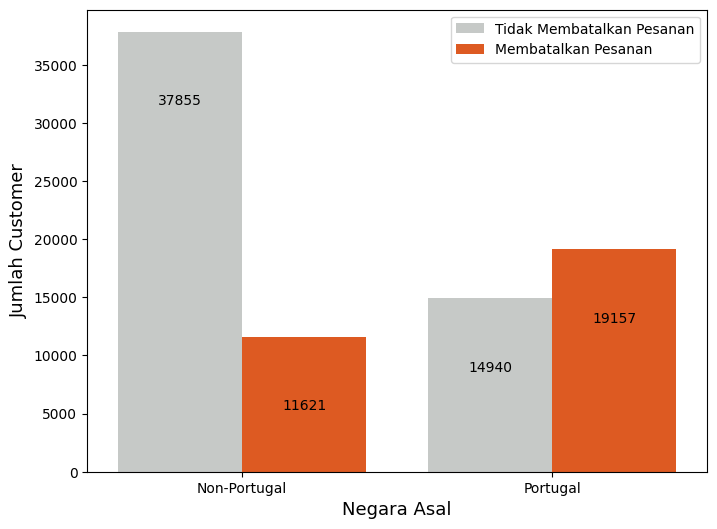

In [69]:
def country(df):
    if df['country'] == 'PRT':
        return "Portugal"
    else:
        return "Non-Portugal"

# DataFrame sementara untuk plot kolom country   
df_categ = data.copy()
df_categ['country'] = df_categ.apply(country, axis=1)

# figsize
plt.figure(figsize=(8,6))



# sns.countplot(df_categ, x='country');

country_plot = sns.countplot(
    data=df_categ, 
    x="country",
    hue='is_canceled',
    palette=['#C5C9C7', '#fc4e03']
)

# annotation
for bar in country_plot.patches:
    country_plot.annotate(
        format(bar.get_height(), '.0f'), (bar.get_x() + bar.get_width() / 2, bar.get_height() + 2), 
        ha='center', 
        va='center',
        size=10, 
        xytext=(0, -50),
        textcoords='offset points')

# x dan y label
plt.xlabel("Negara Asal", loc='center', size=13)
plt.ylabel("Jumlah Customer", loc='center', size=13)

# legend
country_plot.legend(['Tidak Membatalkan Pesanan', 'Membatalkan Pesanan'], loc='upper right')

# show
plt.show()

**_Insight_:**
- Jumlah customer yang negara asalnya bukan dari Portugal dan tidak membatalkan pesanan lebih banyak daripada customer dengan negara asalnya Portugal
- Jumlah customer yang negara asalnya dari Portugal dan membatalkan pesanan lebih banyak daripada customer dengan negara asalnya bukan dari Portugal
<br>
**TETAPI**,
- kolom `country` ini merupakan asal negara pemesan, jika ini dipertimbangkan dalam pemodelan, hal ini tentu akan bersifat **subjektif**. Negara asal dalam hal ini bukan negara tempat di mana customer berdomisili. Jadi, mungkin saja customer dengan country "A", tapi tidak berdomisili di country "A" tersebut.

### Cek Imbalance Data

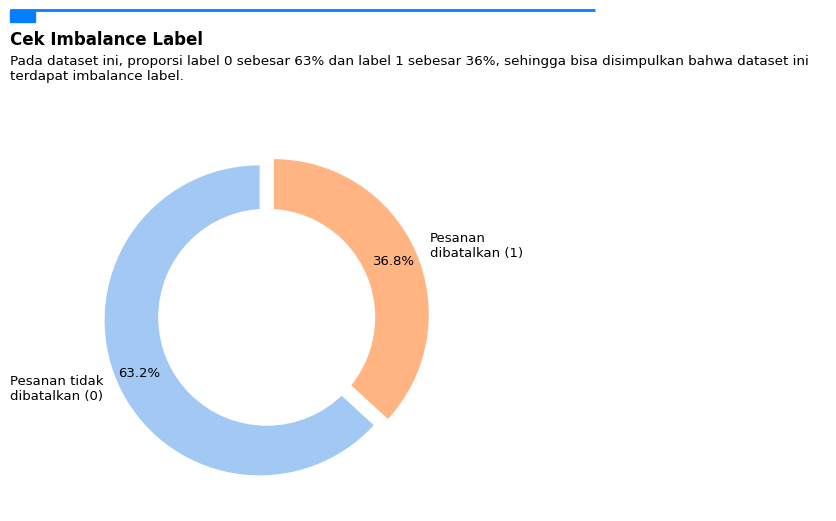

In [18]:
# DataFrame
temp_df = data['is_canceled'].value_counts(normalize=True) * 100

# initialize plot
fig, ax = plt.subplots(figsize=(5, 5))

# adjust the subplot so that the title would fit
plt.subplots_adjust(top=0.9)

# add line and rectangle on top.
fig.add_artist(lines.Line2D([0, 1.17], [1.12, 1.12], lw=2, color='#057eff', solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 1.095), 0.05, 0.025, color='#057eff'))

# add title
fig.text(
    0, 1.05, "Cek Imbalance Label", 
    fontsize=12,
    fontweight="bold", 
)

# add subtitle
fig.text(
    0, 0.98, 
    "Pada dataset ini, proporsi label 0 sebesar 63% dan label 1 sebesar 36%, sehingga bisa disimpulkan bahwa dataset ini\
    \nterdapat imbalance label.",
    fontsize=9.7, 
    color='black'
)
# create pie chart
plt.pie(x=[temp_df.loc[0], temp_df.loc[1]], 
        colors=sns.color_palette('pastel'),
        labels=['Pesanan tidak\ndibatalkan (0)', 'Pesanan\ndibatalkan (1)'], 
        autopct='%1.1f%%', 
        startangle=90, 
        pctdistance=0.85, 
        explode=(0.05, 0.05),
        textprops = {"fontsize": 9.5},
)

# create a circle at the center of the plot
fig = plt.gcf()
fig.gca().add_artist(plt.Circle((0, 0), 0.7, fc='white'));

**_Insight_**:
- Terdapat imbalance label pada dataset ini, sehingga salah satu cara untuk mengatasi hal ini dengan menggunakan metric evaluasi yang robust terhadap imbalance dataset. Dalam hal ini saya menggunakan metric evaluasi **MCC (Matthew Correlation Coefficient)**.
- Cancellation rate pada dataset ini sebesar 36% atau bisa dikatakan bahwa **4 dari 10 pesanan dibatalkan**. Berdasarkan jurnal pada problem statement, hal ini berpengaruh negatif terhadap revenue hotel.

## `Data Preperation`

<h3><span style="color:#0ad0f7">Drop Duplikat Data</span></h3>

In [54]:
# drop duplikat data
data = data.drop_duplicates(keep='last', ignore_index=True)

<h3><span style="color:#0ad0f7">Drop Kolom Country</span></h3>

In [55]:
# drop kolom country
data = data.drop(columns=['country'], axis=1)
data.shape

(10202, 10)

<h3><span style="color:#0ad0f7">Outlier Detection</span></h3>

An outlier is a data point that is significantly different from the remaining data. ([Referensi](https://charuaggarwal.net/outlierbook.pdf))
- Outliers Detection Method: **Multivariate Detection** menggunakan algoritma DBSCAN. Karena pada pairplot yang telah dilakukan pada Data Understanding, dapat disimpulkan bahwa terdapat multivariate outlier.
- DBSCAN termasuk kedalam algoritma clustering, dimana hasil prediksinya berupa cluster-cluster dan jika didalam dataset kita terdapat noise/outlier maka cluster noise/outlier tersebut akan dilabeli dengan **-1**.
- Handling Outliers: **Remove from the dataset**. Outlier dapat mengakibatkan bias interpretasi dalam pembuatan model machine learning. Walaupun ada beberapa model yang **robust** terhadap outlier seperti model-model yang berbasis **Tree**, tetapi agar lebih **fair** dalam melakukan benchmark model nantinya, saya akan menghapus outliers dari dataset.
- Metric evaluasi yang akan digunakan untuk clustering adalah **silhouette_score** dan **calinski_harabasz_score**.

In [56]:
transformer = ColumnTransformer([
    ('binaryencod', ce.BinaryEncoder(), ['market_segment', 'reserved_room_type']),
    ('onehot', OneHotEncoder(), ['deposit_type', 'customer_type']),
    ('scaller', StandardScaler(),['previous_cancellations', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests', 'is_canceled'])
    ], remainder='passthrough')

# fitting and transforming
data_encoded = pd.DataFrame(transformer.fit_transform(data), columns=transformer.get_feature_names_out())
data_encoded = data_encoded.astype(int)
data_encoded.sample(10)

,binaryencod__market_segment_0,binaryencod__market_segment_1,binaryencod__market_segment_2,binaryencod__market_segment_3,binaryencod__reserved_room_type_0,binaryencod__reserved_room_type_1,binaryencod__reserved_room_type_2,binaryencod__reserved_room_type_3,onehot__deposit_type_No Deposit,onehot__deposit_type_Non Refund,...,onehot__customer_type_Contract,onehot__customer_type_Group,onehot__customer_type_Transient,onehot__customer_type_Transient-Party,scaller__previous_cancellations,scaller__booking_changes,scaller__days_in_waiting_list,scaller__required_car_parking_spaces,scaller__total_of_special_requests,scaller__is_canceled
9231,0,0,0,1,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,1,1
2887,0,1,0,1,0,1,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0
256,0,1,0,1,0,1,0,0,1,0,...,0,0,1,0,1,0,0,0,1,0
5138,0,0,0,1,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,1,1
9141,0,1,0,0,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2233,0,0,0,1,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,1,1
5788,0,1,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,0
891,0,0,0,1,0,1,1,1,1,0,...,0,0,1,0,0,0,0,0,0,0
6274,0,0,0,1,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,1
560,0,0,1,0,0,1,0,1,1,0,...,0,0,1,0,0,1,0,2,0,0


In [48]:
# metric evaluation
silhouette = []
calinski_harabasz = []

# min sample and epsilon
n_sample = []
n_eps = []

for i in np.arange(1, 55, 5):
    for j in np.arange(0.1, 1.1, 0.1):
        # fit and predict
        model = DBSCAN(min_samples=i, eps=j)
        model = model.fit_predict(data_encoded)

        # append nilai silhouette score dan calinski_harabasz_score
        silhouette.append(silhouette_score(data_encoded, model, random_state=22))
        calinski_harabasz.append(calinski_harabasz_score(data_encoded, model))

        # append nilai sample dan nilai epsilon
        n_sample.append(i)
        n_eps.append(j)
    
# labels = model.labels_
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# n_noise_ = list(labels).count(-1)

# print("Estimated number of clusters: %d" % n_clusters_)
# print("Estimated number of noise points: %d" % n_noise_)

# DataFrame yang sudah diprediksi
# data['Cluster'] = model

# DataFrame
# pd.set_option('display.max_rows', 500)
df_score = pd.DataFrame(
    {
        'min_sample' : n_sample,
        'epsilon' : n_eps,
        'silhouette_score' : silhouette,
        'calinski_harabasz_score' : calinski_harabasz
    }
)
display(df_score)

# jumlah cluster
# print(f"Jumlah cluster : {data.Cluster.nunique()} cluster")

# return max silhouette score dan calinski_harabasz_score
print(f"Maximum silhouette_score adalah dengan min sample {n_sample[silhouette.index(max(silhouette))]} dan epsilon {n_eps[silhouette.index(max(silhouette))]} --> silhouette_score : {max(silhouette)}")
print(f"Maximum calinski_harabasz_score adalah dengan min sample {n_sample[calinski_harabasz.index(max(calinski_harabasz))]} dan epsilon {n_eps[calinski_harabasz.index(max(calinski_harabasz))]} --> calinski_harabasz_score : {max(calinski_harabasz)}")

# jumlah outlier dalam persen
# print(f"""Jumlah outlier data (multivariate detection) sebesar : {data.query("Cluster == -1").shape[0]} baris atau {round(data.query("Cluster == -1").shape[0]/len(data) * 100)}%""")

,min_sample,epsilon,silhouette_score,calinski_harabasz_score
0,1,0.1,0.942658,1.000000
1,1,0.2,0.942658,1.000000
2,1,0.3,0.942658,1.000000
3,1,0.4,0.942658,1.000000
4,1,0.5,0.942658,1.000000
...,...,...,...,...
105,51,0.6,0.202406,62.943949
106,51,0.7,0.202406,62.943949
107,51,0.8,0.202406,62.943949
108,51,0.9,0.202406,62.943949


Maximum silhouette_score adalah dengan min sample 1 dan epsilon 0.1 --> silhouette_score : 0.9426583022936679
Maximum calinski_harabasz_score adalah dengan min sample 51 dan epsilon 1.0 --> calinski_harabasz_score : 345.43629730576856


In [86]:
# save into csv file
# df_score.to_csv(r"C:\Users\faisa\Desktop\DataSciencePurwadhika\Modul3ML\HotelBookingDemand\data\processed\dbscan_score.csv")

# DataFrame experimen pertama untuk mencari nilai min sample dan nilai epsilon terbaik
# df_score = pd.read_csv(r"C:\Users\faisa\Desktop\DataSciencePurwadhika\Modul3ML\HotelBookingDemand\data\processed\dbscan_score.csv", index_col = [0])

# # plot grafik antara min_sample, nilai epsilon dengan masing-masing metric evaluasi clustering
# fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13,10))

# gr1 = sns.lineplot(df_score, x='min_sample', y='silhouette_score', markers=True, dashes=False, style='min_sample', ax=ax1)
# gr2 = sns.lineplot(df_score, x='epsilon', y='silhouette_score', markers=True, dashes=False, style='epsilon', ax=ax2)

# gr3 = sns.lineplot(df_score, x='min_sample', y='calinski_harabasz_score', markers=True, dashes=False, style='min_sample', ax=ax3)
# gr4 = sns.lineplot(df_score, x='epsilon', y='calinski_harabasz_score', markers=True, dashes=False, style='epsilon', ax=ax4)

# # df_score.min_sample.unique()
# for i, txt in enumerate(df_score.min_sample.unique()):
#     gr1.text(x=df_score.min_sample.unique()[i], y=df_score.silhouette_score.unique()[i], s=txt, horizontalalignment='left',
#      verticalalignment='bottom')

# plt.show()

In [52]:
# metric evaluation
silhouette1 = []
calinski_harabasz1 = []

# min sample and epsilon
n_sample1 = []
n_eps1 = []

for i in [1,51]:
    for j in np.arange(0.1, 10.1, 0.1):
        # fit and predict
        model = DBSCAN(min_samples=i, eps=j)
        model = model.fit_predict(data_encoded)

        # append nilai silhouette score dan calinski_harabasz_score
        silhouette1.append(silhouette_score(data_encoded, model, random_state=22))
        calinski_harabasz1.append(calinski_harabasz_score(data_encoded, model))

        # append nilai sample dan nilai epsilon
        n_sample1.append(i)
        n_eps1.append(j)

# DataFrame
pd.set_option('display.max_rows', 500)
df_score1 = pd.DataFrame(
    {
        'min_sample1' : n_sample1,
        'epsilon1' : n_eps1,
        'silhouette_score1' : silhouette1,
        'calinski_harabasz_score1' : calinski_harabasz1
    }
)
display(df_score1)

# return max silhouette score dan calinski_harabasz_score
print(f"Maximum silhouette_score adalah dengan min sample {n_sample1[silhouette1.index(max(silhouette1))]} dan epsilon {n_eps1[silhouette1.index(max(silhouette1))]} --> silhouette_score : {max(silhouette1)}")
print(f"Maximum calinski_harabasz_score adalah dengan min sample {n_sample1[calinski_harabasz1.index(max(calinski_harabasz1))]} dan epsilon {n_eps1[calinski_harabasz1.index(max(calinski_harabasz1))]} --> calinski_harabasz_score : {max(calinski_harabasz1)}")

,min_sample1,epsilon1,silhouette_score1,calinski_harabasz_score1
0,1,0.1,0.942658,1.000000
1,1,0.2,0.942658,1.000000
2,1,0.3,0.942658,1.000000
3,1,0.4,0.942658,1.000000
4,1,0.5,0.942658,1.000000
5,1,0.6,0.942658,1.000000
6,1,0.7,0.942658,1.000000
7,1,0.8,0.942658,1.000000
8,1,0.9,0.942658,1.000000
9,1,1.0,-0.023188,86.468613


Maximum silhouette_score adalah dengan min sample 1 dan epsilon 0.1 --> silhouette_score : 0.9426583022936679
Maximum calinski_harabasz_score adalah dengan min sample 51 dan epsilon 6.1 --> calinski_harabasz_score : 1353.72366826665


**_Insight_:**
- `Sweet spot` untuk nilai parameter minimum sample dan epsilon berada diangka **minimum sample 46 dan epsilon 6.1** karena pada angka tersebut menghasilkan **silhouette_score sebesar 0.84 dan calinski_harabasz_score sebesar 1365.27**.
- Nilai parameter tersebut akan digunakan untuk memprediksi bagaimana sebasaran data pada dataset ini.

In [87]:
# save into csv file
# df_score1.to_csv(r"C:\Users\faisa\Desktop\DataSciencePurwadhika\Modul3ML\HotelBookingDemand\data\processed\dbscan_score1.csv")

In [57]:
model = DBSCAN(min_samples=51, eps=6.1)
model.fit(data_encoded)
cluster = model.labels_

# DataFrame dengan Cluster
data_encoded['Cluster'] = cluster
display(data_encoded.sample(10))

# Jumlah cluster dan jumlah outlier
print(f"Jumlah cluster berdasarkan algoritma DBSCAN sebanyak {data_encoded.Cluster.nunique()} cluster, yaitu cluster {data_encoded.Cluster.value_counts().index[0]} dan cluster {data_encoded.Cluster.value_counts().index[1]}")

# Percentage jumlah outlier
print(f"Jumlah data yang outlier sebanyak {data_encoded.Cluster.value_counts()[-1]} baris atau {round((data_encoded.Cluster.value_counts(normalize=True) * 100).values[1],2)}%")

,binaryencod__market_segment_0,binaryencod__market_segment_1,binaryencod__market_segment_2,binaryencod__market_segment_3,binaryencod__reserved_room_type_0,binaryencod__reserved_room_type_1,binaryencod__reserved_room_type_2,binaryencod__reserved_room_type_3,onehot__deposit_type_No Deposit,onehot__deposit_type_Non Refund,...,onehot__customer_type_Group,onehot__customer_type_Transient,onehot__customer_type_Transient-Party,scaller__previous_cancellations,scaller__booking_changes,scaller__days_in_waiting_list,scaller__required_car_parking_spaces,scaller__total_of_special_requests,scaller__is_canceled,Cluster
9069,0,0,0,1,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
9218,0,0,0,1,0,0,1,1,1,0,...,0,1,0,0,0,0,0,0,0,0
8128,0,1,0,0,0,0,1,0,1,0,...,0,1,0,0,0,0,4,0,0,0
510,0,0,0,1,0,1,1,1,1,0,...,0,1,0,0,0,0,2,0,0,0
5628,0,1,1,1,0,0,1,0,1,0,...,0,0,1,0,0,0,2,0,0,0
7171,0,0,0,1,0,0,1,0,1,0,...,0,1,0,0,0,0,0,1,0,0
580,0,0,0,1,0,0,1,0,1,0,...,0,1,0,0,0,0,2,1,0,0
6828,0,0,0,1,0,1,0,0,1,0,...,0,1,0,0,2,0,0,0,0,0
8675,0,0,0,1,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
4801,0,1,1,1,0,1,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0


Jumlah cluster berdasarkan algoritma DBSCAN sebanyak 2 cluster, yaitu cluster 0 dan cluster -1
Jumlah data yang outlier sebanyak 31 baris atau 0.3%


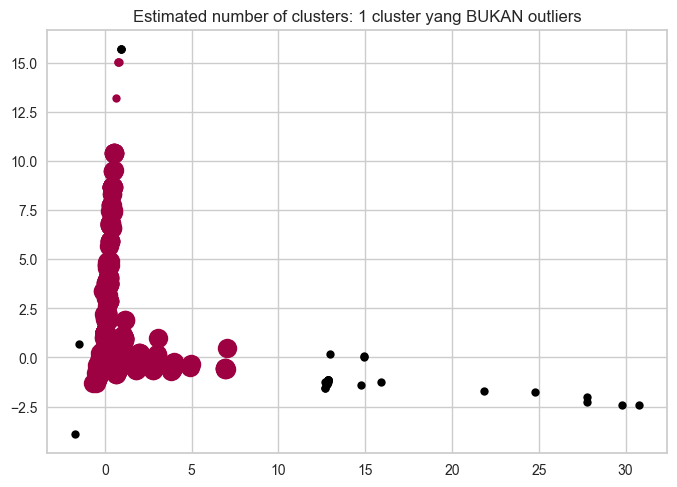

In [55]:
# visualisasi plot cluster menggunakan 2D PCA

# PCA estimator with 2 PC
pca = PCA(n_components=2, random_state=22, svd_solver='full')
pca.fit(data_encoded)
data_norm = pca.transform(data_encoded)

# jumlah cluster yang bukan outlier
n_clusters_ = len(set(cluster)) - (1 if -1 in cluster else 0)

# jumlah unique cluster
unique_labels = set(cluster)
core_samples_mask = np.zeros_like(cluster, dtype=bool)
core_samples_mask[model.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = cluster == k

    xy = data_norm[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = data_norm[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_} cluster yang BUKAN outliers")
plt.show()

In [56]:
# plot using 3D PCA
pca = PCA(n_components=3, random_state=22, svd_solver='full') 
data_encoded_pca = pca.fit_transform(data_encoded)

# DataFrame untuk plot
df_plot = pd.DataFrame(data_encoded_pca, columns=['PC1', 'PC2', 'PC3'])
df_plot['Cluster'] = cluster

fig = px.scatter_3d(data_frame=df_plot, x='PC1', y='PC2', z='PC3',
            color='Cluster', color_continuous_scale=px.colors.sequential.Hot, title='3D outlier plot')
fig.show();

In [58]:
# remove outliers
data['Cluster'] = cluster
data = data.query("~(Cluster == -1)")
data.shape

(10171, 11)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

transformer1 = ColumnTransformer([
    ('encoder', ce.BinaryEncoder(), ['market_segment', 'deposit_type', 'customer_type', 'reserved_room_type']),
    ('scaller', MinMaxScaler((0,1)),['previous_cancellations', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests', 'is_canceled'])
    ], remainder='passthrough')

# fitting and transforming
data_encoded1 = pd.DataFrame(transformer1.fit_transform(data), columns=transformer1.get_feature_names_out())
data_encoded1 = data_encoded1.astype(int)
data_encoded1.sample(10)


# # plot using 2D PCA
# # PCA estimator with 2 PC
# pca = PCA(n_components=2, svd_solver='full')
# pca.fit(data_encoded1)
# data_norm = pca.transform(data_encoded1)

# print(f"PCA score : {pca.explained_variance_ratio_}")

pca = PCA().fit(data_encoded1)

print(pca.explained_variance_ratio_)
plt.figure(figsize=(15,10))
plt.ylim(0.0,1.1)
plt.plot(np.cumsum(pca.explained_variance_ratio_), linewidth=3)
# plt.axhline(y=0.95, color='r', linestyle='-')
# plt.text(500, 0.85, '95% cut-off threshold', color = 'red', fontsize=14)
plt.xlabel('number of components', fontsize=21)
plt.ylabel('cumulative explained variance', fontsize=21)
plt.title('Scree Plot using PCA', fontsize=24)
plt.rc('xtick', labelsize=16)
plt.rc('font', size=16)
# plt.rc('ytick', labelsize=16)
plt.grid()
plt.show()

<h3><span style="color:#0ad0f7">Rare Value Detection</span></h3>
<h5>1️⃣ Numerical Variable</h5>

Handling: **Diskritisasi**

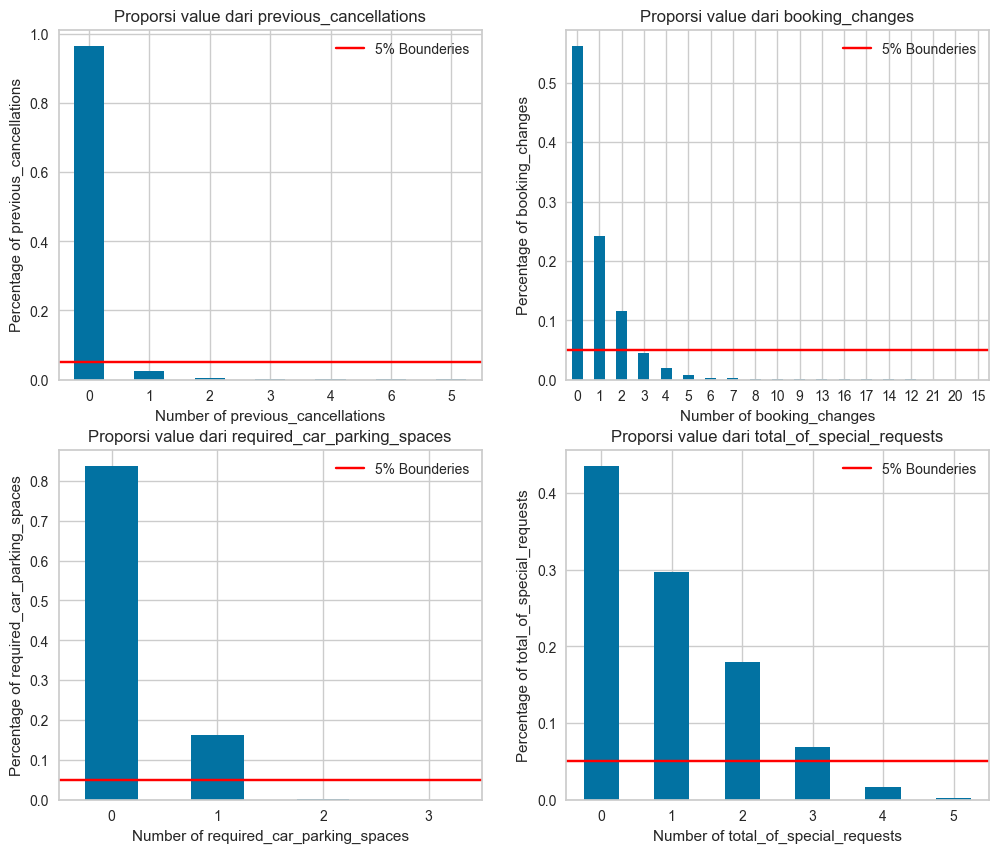

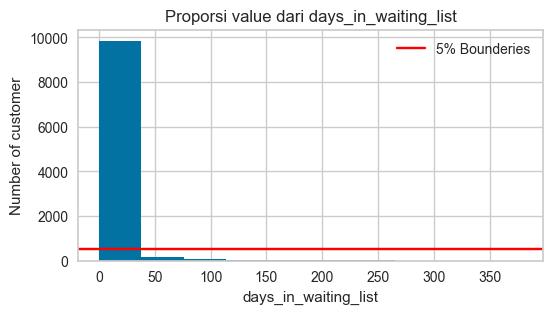

In [59]:
# kolom 'previous_cancellations', 'booking_changes', 'required_car_parking_spaces', 'total_of_special_requests'
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

row1 = [ax1,ax2]
row2 = [ax3,ax4]
col1 = ['previous_cancellations', 'booking_changes']
col2 = ['required_car_parking_spaces', 'total_of_special_requests']
title1 = ['Proporsi value dari previous_cancellations','Proporsi value dari booking_changes']
title2 = ['Proporsi value dari required_car_parking_spaces','Proporsi value dari total_of_special_requests']

for i in zip(row1, row2, col1, col2, title1, title2):
    # DataFrame
    temp_df1 = pd.Series(data[i[2]].value_counts() / len(data)).sort_values(ascending=False).plot(kind='bar', label='', ax=i[0])
    temp_df2 = pd.Series(data[i[3]].value_counts() / len(data)).sort_values(ascending=False).plot(kind='bar', label='', ax=i[1])
    # set title
    i[0].set_title(i[-2])
    i[1].set_title(i[-1])
    # horizontal line: boundary yang digunakan adalah 5%, di bawah 5% akan diasumsikan sebagai rare value
    i[0].axhline(y=0.05, color='red', label='5% Bounderies')
    i[1].axhline(y=0.05, color='red', label='5% Bounderies')
    # set x label and its rotation
    i[0].tick_params(axis='x', labelrotation=360)
    i[1].tick_params(axis='x', labelrotation=360)
    i[0].set_xlabel(f"Number of {i[2]}")
    i[1].set_xlabel(f"Number of {i[3]}")
    # ylabel
    i[0].set_ylabel(f'Percentage of {i[2]}')
    i[1].set_ylabel(f'Percentage of {i[3]}')
    # legend
    i[0].legend()
    i[1].legend()


# kolom days_in_waiting_list
# figure and title
plt.figure(figsize=(6, 3))
plt.title("Proporsi value dari days_in_waiting_list")
fig = data['days_in_waiting_list'].sort_values(ascending=False).plot.hist(rot=0, label='')

# set x and y label
fig.set_xlabel('days_in_waiting_list')
fig.set_ylabel('Number of customer')

# set horizontal line
fig.axhline(y=0.05*len(data), color='red', label=f'5% Bounderies')

# legend
plt.legend()

# show graph
plt.show()

**_Insight_**:
1. Boundary yang digunakan adalah **5%**, di bawah 5% akan diasumsikan sebagai **rare value**
2. Pada kolom previous_cancellations akan didiskrititasi dengan --> **pernah membatalkan pesanan sebelumnya (1) atau tidak pernah sama sekali (0)**
3. Pada kolom booking_changes akan didiskrititasi dengan --> **tidak melakukan perubahan booking (0), melakukan 1x perubahan (1), dan melakukan lebih dari 1x perubahan (2)**
4. Pada kolom total_of_special_requests akan didiskrititasi dengan --> **tidak ada request (0), ada 1 request (1), ada 2 request (2), ada 3 request (3), dan lebih dari 3 request (4)** (example of request:twin bed, high floor, etc)
5. Pada kolom days_in_waiting_list akan didiskrititasi dengan --> **langsung dikonfirmasi oleh pihak hotel (0) atau tidak (1)**
6. **Tidak terdapat rare value** pada kolom required_car_parking_spaces

In [60]:
# Diskritisasi Kolom Numerical
data['previous_cancellations'] = data['previous_cancellations'].apply(lambda x: 1 if x >= 1 else 0)
data['booking_changes'] = data['booking_changes'].apply(lambda x: 1 if x>=3 else x)
data['total_of_special_requests'] = data['total_of_special_requests'].apply(lambda x: 1 if x>=3 else x)
data['days_in_waiting_list'] = data['days_in_waiting_list'].apply(lambda x: 1 if x>=1 else x)

<h5>2️⃣ Categorical Variable</h5>

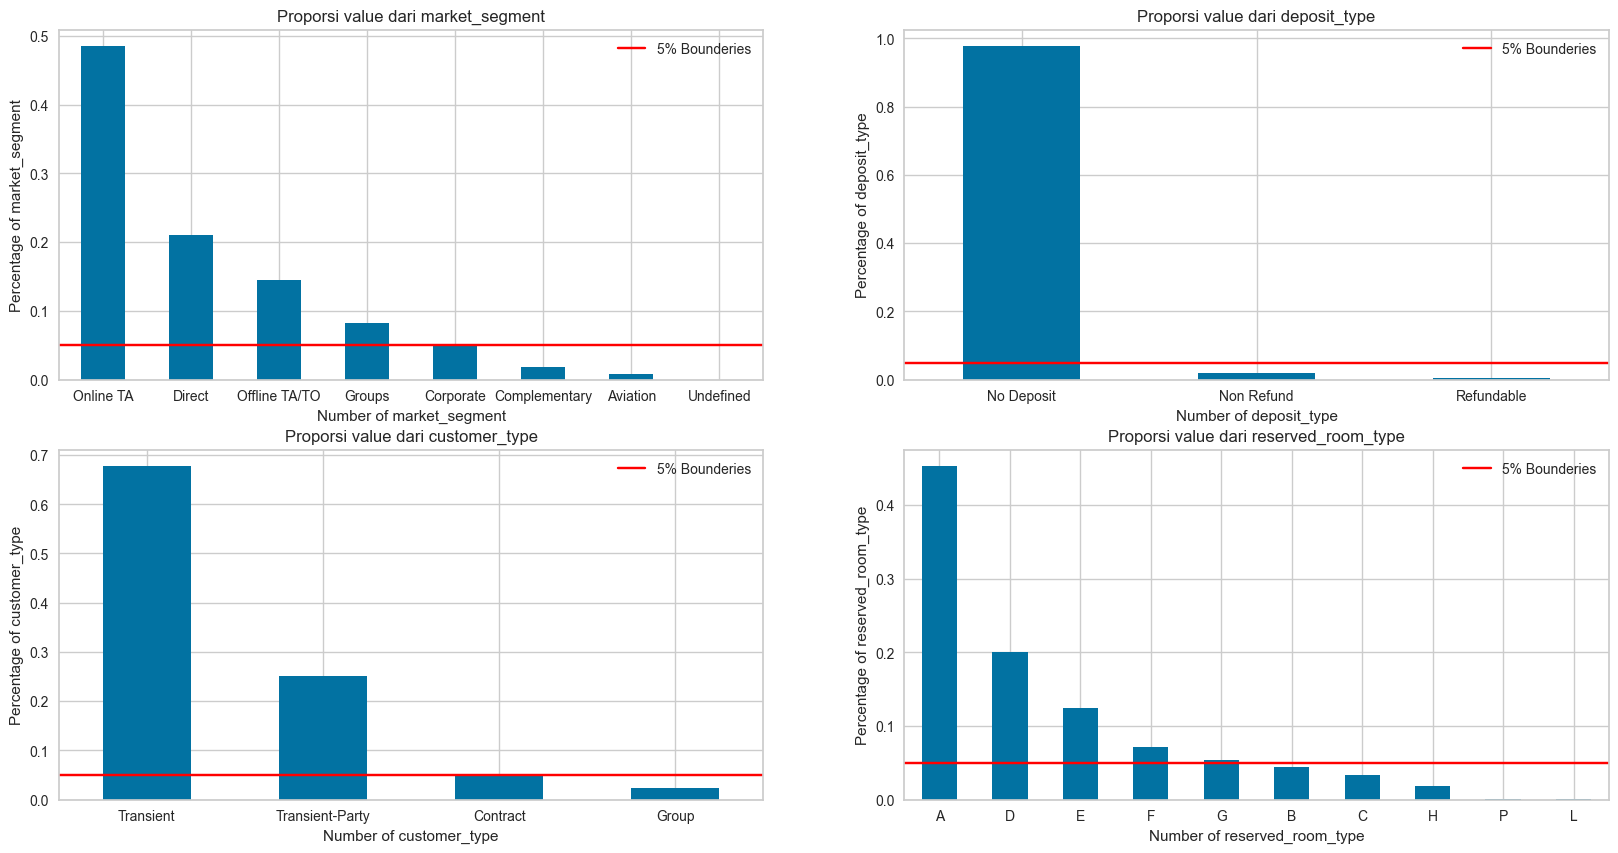

In [61]:
# kolom 'previous_cancellations', 'booking_changes', 'required_car_parking_spaces', 'total_of_special_requests'
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20,10))

row1 = [ax1,ax2]
row2 = [ax3,ax4]
col1 = ['market_segment', 'deposit_type']
col2 = ['customer_type', 'reserved_room_type']
title1 = ['Proporsi value dari market_segment','Proporsi value dari deposit_type']
title2 = ['Proporsi value dari customer_type','Proporsi value dari reserved_room_type']

for i in zip(row1, row2, col1, col2, title1, title2):
    # DataFrame
    temp_df1 = pd.Series(data[i[2]].value_counts() / len(data)).sort_values(ascending=False).plot(kind='bar', label='', ax=i[0])
    temp_df2 = pd.Series(data[i[3]].value_counts() / len(data)).sort_values(ascending=False).plot(kind='bar', label='', ax=i[1])
    # set title
    i[0].set_title(i[-2])
    i[1].set_title(i[-1])
    # horizontal line: boundary yang digunakan adalah 5%, di bawah 5% akan diasumsikan sebagai rare value
    i[0].axhline(y=0.05, color='red', label='5% Bounderies')
    i[1].axhline(y=0.05, color='red', label='5% Bounderies')
    # set x label and its rotation
    i[0].tick_params(axis='x', labelrotation=360)
    i[1].tick_params(axis='x', labelrotation=360)
    i[0].set_xlabel(f"Number of {i[2]}")
    i[1].set_xlabel(f"Number of {i[3]}")
    # ylabel
    i[0].set_ylabel(f'Percentage of {i[2]}')
    i[1].set_ylabel(f'Percentage of {i[3]}')
    # legend
    i[0].legend()
    i[1].legend()

In [ ]:
categ_kolom = ['market_segment', 'deposit_type', 'customer_type', 'reserved_room_type']

In [62]:
# Diskritisasi Kolom Categorical
data['market_segment'] = data['market_segment'].apply(lambda x: 'Others' if x in ['Complementary', 'Aviation', 'Undefined'] else x)
data['reserved_room_type'] = data['reserved_room_type'].apply(lambda x: 'Others' if x in ['B', 'C', 'H', 'P', 'L'] else x)

In [63]:
data = data.drop_duplicates(keep='last', ignore_index=True)
data.shape

(1633, 11)

## `Modelling`

------
-----
-----

In [153]:
# DataFrame
# data = data.drop(columns='Cluster')

# split train dan test
dfTrain, dfTest = train_test_split(data, test_size=0.2, random_state=22, stratify=data['is_canceled'])

# # data train
# X_train = dfTrain.drop(columns='is_canceled')
# y_train = dfTrain['is_canceled']

# # data test
# X_test = dfTest.drop(columns='is_canceled')
# y_test = dfTest['is_canceled']

display(dfTrain.shape, dfTest.shape)

(1306, 10)

(327, 10)

In [154]:
from pycaret.internal.preprocess.transformers import TransformerWrapper
from sklearn.preprocessing import PolynomialFeatures

customePipeline =[
    # ('polynomial', TransformerWrapper(include=['previous_cancellations'], transformer=PolynomialFeatures(degree=3))),
    # ('scaleler', TransformerWrapper(include=['previous_cancellations','booking_changes','days_in_waiting_list','required_car_parking_spaces','total_of_special_requests'], transformer=MinMaxScaler((0,1)))),
    ('onehot', TransformerWrapper(include=['deposit_type', 'market_segment', 'reserved_room_type', 'customer_type'], transformer=OneHotEncoder()))
    # ('binary', TransformerWrapper(include=['market_segment', 'reserved_room_type', 'customer_type'], transformer=ce.BinaryEncoder()))
]

interval columns not set, guessing: ['previous_cancellations', 'booking_changes', 'required_car_parking_spaces', 'total_of_special_requests', 'is_canceled']
interval columns not set, guessing: ['is_canceled']


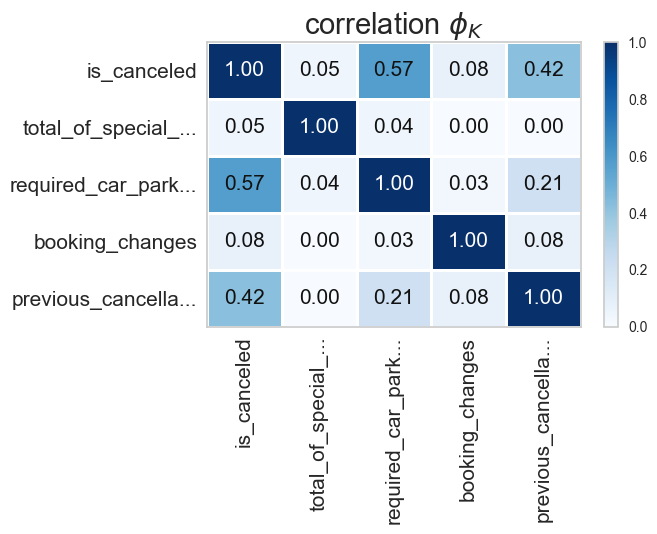

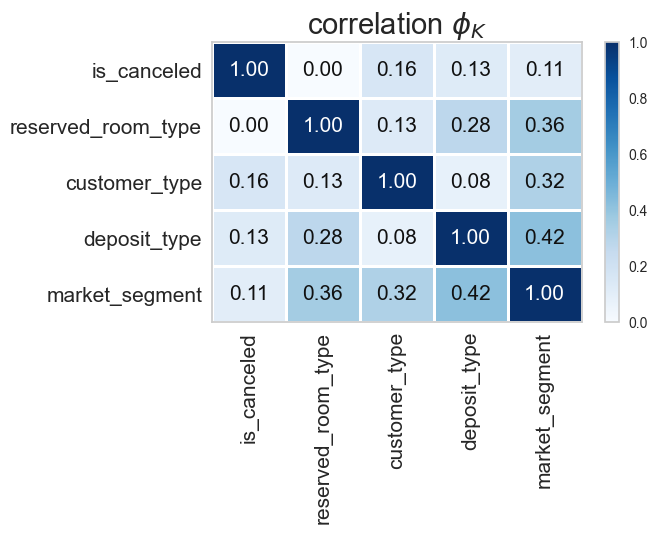

In [72]:
# import module
import phik
from phik.report import plot_correlation_matrix
from phik import report

numeric_cols = ['previous_cancellations', 'booking_changes', 'required_car_parking_spaces', 'total_of_special_requests', 'is_canceled']
cat_cols = ['market_segment', 'deposit_type', 'customer_type', 'reserved_room_type', 'is_canceled']

phik_overview = data[numeric_cols].phik_matrix()

plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(7,5.5))

# significance between those columns
phik_overview = data[cat_cols].phik_matrix()

plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(7,5.5))

plt.tight_layout()

In [ ]:
market_segment # binary
deposit_type # one hot
customer_type # one hot
reserved_room_type # binary

In [155]:
from pycaret.classification import *

cls = setup(
    # random_state
    session_id=2020,

    # define numerical variable dan categorical variable
    # numeric_features=['previous_cancellations', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests'],
    # categorical_features=['market_segment', 'deposit_type', 'customer_type', 'reserved_room_type'],

    # data yang digunakan untuk membangun model, split data validation, dan target
    data=dfTrain,
    train_size=0.8,
    target='is_canceled',

    # handling multicollinearity
    # remove_multicollinearity=True,
    # multicollinearity_threshold=0.8,

    # ignore_features=['booking_changes', 'total_of_special_requests'],

    # re-scaling data
    # normalize=True,
    # normalize_method='zscore',
    # max_encoding_ohe=0,
    # encoding_method=ce.cat_boost.CatBoostEncoder(),

    # feature creation
    # polynomial_features=True,
    # polynomial_degree=2
    preprocess=False,
    custom_pipeline=customePipeline,
    custom_pipeline_position=0
)

,Description,Value
0,Session id,2020
1,Target,is_canceled
2,Target type,Binary
3,Original data shape,"(1306, 10)"
4,Transformed data shape,"(1306, 25)"
5,Transformed train set shape,"(1044, 25)"
6,Transformed test set shape,"(262, 25)"
7,Numeric features,5
8,Categorical features,4


In [156]:
# add balanced_accucary metric
from sklearn.metrics import balanced_accuracy_score, fbeta_score

add_metric(
    'balanced', 'Bal. Acc', balanced_accuracy_score, greater_is_better = True
           )

add_metric(
    'f2', 'F2', fbeta_score, greater_is_better = True, beta=2
           )

# remove_metric("F1")

Name                                                           F2
Display Name                                                   F2
Score Function       <function fbeta_score at 0x0000026AEF367670>
Scorer                           make_scorer(fbeta_score, beta=2)
Target                                                       pred
Args                                                  {'beta': 2}
Greater is Better                                            True
Multiclass                                                   True
Custom                                                       True
Name: f2, dtype: object

In [157]:
best = compare_models(include = ['svm', 'ridge', 'lr', 'knn', 'dt', 'ada', 'gbc', 'lda', 'lightgbm', 'rf'], sort='MCC')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:16:08
Status,. . . . . . . . . . . . . . . . . .,Selecting Estimator
Estimator,. . . . . . . . . . . . . . . . . .,SVM - Linear Kernel


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Bal. Acc,F2,TT (Sec)
lr,Logistic Regression,0.7328,0.8013,0.4235,0.6424,0.5076,0.3348,0.3502,0.6529,0.4532,4.3590
lda,Linear Discriminant Analysis,0.7318,0.8026,0.4118,0.6453,0.4987,0.3283,0.3459,0.6491,0.4421,4.4440
ada,Ada Boost Classifier,0.7270,0.8014,0.4471,0.6148,0.5152,0.3324,0.3418,0.6547,0.4717,4.5460
svm,SVM - Linear Kernel,0.7117,0.0000,0.4559,0.6339,0.4951,0.3076,0.3347,0.6455,0.4656,4.9550
ridge,Ridge Classifier,0.7280,0.0000,0.3853,0.6449,0.4780,0.3104,0.3313,0.6394,0.4172,4.3090
gbc,Gradient Boosting Classifier,0.7213,0.7754,0.3882,0.6160,0.4724,0.2976,0.3136,0.6352,0.4176,4.7070
lightgbm,Light Gradient Boosting Machine,0.6380,0.7214,0.3706,0.4416,0.3965,0.1431,0.1468,0.5689,0.3797,4.4370
knn,K Neighbors Classifier,0.6389,0.6273,0.3235,0.4367,0.3671,0.1237,0.1284,0.5574,0.3390,4.7880
rf,Random Forest Classifier,0.6025,0.6139,0.3294,0.3732,0.3467,0.0653,0.0656,0.5319,0.3356,4.5050
dt,Decision Tree Classifier,0.5891,0.5174,0.3176,0.3518,0.3318,0.0380,0.0381,0.5189,0.3228,4.3470


Processing:   0%|          | 0/45 [00:00<?, ?it/s]

In [159]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [160]:
lr = create_model('lr', probability_threshold=0.29)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:27:08
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Bal. Acc,F2
Fold,,,,,,,,,
0,0.5619,0.7216,0.8529,0.4143,0.5577,0.2159,0.2734,0.6377,0.7039
1,0.7238,0.8140,0.8529,0.5472,0.6667,0.4495,0.4819,0.7575,0.7672
2,0.7238,0.8424,0.7647,0.5532,0.6420,0.4264,0.4413,0.7345,0.7104
3,0.6381,0.8213,0.9118,0.4697,0.6200,0.3363,0.4056,0.7094,0.7673
4,0.6923,0.8540,0.9412,0.5161,0.6667,0.4230,0.4901,0.7563,0.8081
5,0.7308,0.8265,0.7647,0.5652,0.6500,0.4391,0.4524,0.7395,0.7143
6,0.6538,0.7935,0.9412,0.4848,0.6400,0.3667,0.4437,0.7277,0.7921
7,0.6923,0.8296,0.9118,0.5167,0.6596,0.4157,0.4723,0.7487,0.7908
8,0.6442,0.7521,0.8235,0.4746,0.6022,0.3201,0.3604,0.6903,0.7179


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [161]:
evaluate_model(lr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [165]:
parameters = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'saga'],
    'C': [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000],
    'max_iter': [100, 150, 200, 250, 500, 1000],
    'class_weight' : ['balanced']
}

tuned_model = tune_model(lr, optimize='MCC', choose_better=True, n_iter=30, search_algorithm='random', search_library='scikit-learn', custom_grid=parameters)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Bal. Acc,F2
Fold,,,,,,,,,
0,0.5238,0.7158,1.0000,0.4048,0.5763,0.2138,0.3460,0.6479,0.7727
1,0.6952,0.8186,0.9706,0.5156,0.6735,0.4342,0.5122,0.7670,0.8250
2,0.6857,0.8428,0.9706,0.5077,0.6667,0.4201,0.5009,0.7599,0.8209
3,0.5524,0.8167,0.9706,0.4177,0.5841,0.2400,0.3498,0.6614,0.7674
4,0.5385,0.8553,1.0000,0.4146,0.5862,0.2306,0.3610,0.6571,0.7798
5,0.6635,0.8273,0.9706,0.4925,0.6535,0.3880,0.4751,0.7424,0.8128
6,0.5769,0.8002,1.0000,0.4359,0.6071,0.2787,0.4024,0.6857,0.7944
7,0.6250,0.8267,1.0000,0.4658,0.6355,0.3420,0.4542,0.7214,0.8134
8,0.5192,0.7571,1.0000,0.4048,0.5763,0.2073,0.3401,0.6429,0.7727


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 30 candidates, totalling 300 fits


In [166]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [164]:
TP = 75
FN = 10

TN = 156
FP = 21

MCC = (TP * TN - (FP * FN)) / np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
MCC

0.7420518840961695

In [44]:
ada = create_model('gbc', probability_threshold=0.49, return_train_score=True, cross_validation=False)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,19:22:45
Status,. . . . . . . . . . . . . . . . . .,Fitting Gradient Boosting Classifier
Estimator,. . . . . . . . . . . . . . . . . .,Gradient Boosting Classifier


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Bal. Acc,F2
Test,0.7429,0.8127,0.4459,0.5946,0.5097,0.3402,0.3467,0.6579,0.4694
Train,0.7913,0.8766,0.4651,0.7407,0.5714,0.4429,0.4638,0.6978,0.5025


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [19]:
parameters = {
    "n_estimators":[150,300,500,700],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[round(i,2) for i in np.arange(0.05, 0.2, 0.01)],
    'min_samples_split': np.linspace(0.1, 1.0, 10, endpoint=True),
    'min_samples_leaf' : np.linspace(0.1, 0.5, 5, endpoint=True),
    'max_features' : list(range(1,get_config('X_train_transformed').shape[1]))
}

tuned_model = tune_model(best, optimize='MCC', choose_better=True, n_iter=10, search_algorithm='tpe', search_library='optuna', custom_grid=parameters)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,18:44:45
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Gradient Boosting Classifier


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Bal. Acc,F2
Fold,,,,,,,,,
0,0.7682,0.8429,0.4667,0.6562,0.5455,0.3958,0.4062,0.6814,0.4953
1,0.7815,0.8318,0.5111,0.6765,0.5823,0.4382,0.4460,0.7037,0.5374
2,0.7748,0.8342,0.5217,0.6667,0.5854,0.4340,0.4401,0.7037,0.5455
3,0.7933,0.8397,0.4889,0.7333,0.5867,0.4561,0.4728,0.7063,0.5238
4,0.7533,0.8439,0.4889,0.6111,0.5432,0.3771,0.3815,0.6778,0.5093
5,0.8000,0.8632,0.4667,0.7778,0.5833,0.4624,0.4885,0.7048,0.5072
6,0.7667,0.8035,0.4000,0.6923,0.5070,0.3682,0.3920,0.6619,0.4369
7,0.7600,0.8043,0.4889,0.6286,0.5500,0.3898,0.3956,0.6825,0.5116
8,0.7000,0.8068,0.3778,0.5000,0.4304,0.2321,0.2363,0.6079,0.3972


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

[I 2023-08-03 18:44:46,095] Searching the best hyperparameters using 1503 samples...
[I 2023-08-03 18:53:30,720] Finished hyperparemeter search!


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [13]:
parameters = {
    "n_estimators":[5,50,250,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}
tuned_model = tune_model(best, optimize='MCC', choose_better=True, n_iter=5, search_algorithm='tpe', search_library='optuna')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7896,0.7666,0.1242,0.8636,0.2171,0.1680,0.2773
1,0.7911,0.7926,0.1569,0.7742,0.2609,0.1973,0.2843
2,0.7972,0.7393,0.1494,0.9583,0.2584,0.2079,0.3323
3,0.7911,0.7876,0.1429,0.8462,0.2444,0.1890,0.2926
4,0.7926,0.7638,0.1494,0.8519,0.2541,0.1975,0.3012
5,0.7834,0.7163,0.1169,0.7826,0.2034,0.1512,0.2459
6,0.8003,0.7832,0.1818,0.8750,0.3011,0.2391,0.3416
7,0.7865,0.7589,0.1169,0.8571,0.2057,0.1579,0.2666
8,0.7938,0.7450,0.1569,0.8276,0.2637,0.2040,0.3017


[I 2023-08-01 22:33:32,746] Searching the best hyperparameters using 6508 samples...
[I 2023-08-01 22:36:34,085] Finished hyperparemeter search!


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [30]:
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
tuned_model = tune_model(best, optimize='MCC', choose_better=True, n_iter=15, search_algorithm='random')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6790,0.7676,0.7516,0.4021,0.5239,0.3138,0.3488
1,0.6851,0.7824,0.7974,0.4122,0.5434,0.3384,0.3815
2,0.6498,0.7391,0.7403,0.3775,0.5000,0.2718,0.3085
3,0.6790,0.7802,0.7792,0.4068,0.5345,0.3246,0.3646
4,0.6866,0.7699,0.7727,0.4132,0.5385,0.3328,0.3702
5,0.6467,0.7381,0.6948,0.3690,0.4820,0.2503,0.2793
6,0.6636,0.7833,0.7338,0.3883,0.5079,0.2874,0.3211
7,0.6774,0.7609,0.7792,0.4054,0.5333,0.3225,0.3628
8,0.6538,0.7479,0.7190,0.3767,0.4944,0.2684,0.3009


Fitting 10 folds for each of 15 candidates, totalling 150 fits


In [20]:
parameters = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'saga'],
    'C': [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000],
    'max_iter': [100, 150, 200]
}

tuned_model = tune_model(best, optimize='MCC', choose_better=True, n_iter=15, search_algorithm='random')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:37:34
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6805,0.7783,0.7059,0.3985,0.5094,0.2988,0.3256
1,0.7081,0.8224,0.7908,0.4337,0.5602,0.3685,0.4058
2,0.7005,0.7731,0.7273,0.4226,0.5346,0.3359,0.3628
3,0.7005,0.8223,0.7987,0.4286,0.5578,0.3611,0.4012
4,0.7020,0.7945,0.7662,0.4275,0.5488,0.3521,0.3855
5,0.7235,0.7963,0.7857,0.4515,0.5735,0.3903,0.4231
6,0.7112,0.8026,0.7532,0.4361,0.5524,0.3609,0.3903
7,0.7250,0.7999,0.7403,0.4506,0.5602,0.3770,0.4016
8,0.7031,0.7874,0.7778,0.4281,0.5522,0.3569,0.3926


Fitting 10 folds for each of 15 candidates, totalling 150 fits


In [21]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

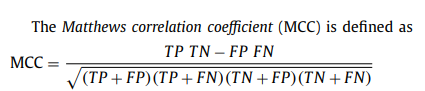

In [125]:
TP = 20
FN = 0

TN = 375
FP = 5

MCC = (TP * TN - (FP * FN)) / np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
MCC

0.8885233166386385